In [1]:
from SimPEG import *
from simpegEM1D import *
from scipy.constants import mu_0
import numpy as np

sig_half = 1e-1
sig_blk = 1e0

# frequency = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
frequency = np.logspace(np.log10(382), np.log10(130100), 5)
hz = get_vertical_discretization_frequency(frequency, sigma_background=sig_half)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

FDsurvey = EM1DSurveyFD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    field_type = 'secondary',
    rx_type = 'Hz',
    src_type = 'VMD',
    offset = np.ones(frequency.size)*7.86,
    topo = np.r_[0., 0., 100.],
    depth = depth,
    frequency = frequency
)

chi_half = 0.
wires = Maps.Wires(('sigma', mesh1D.nC),('h', 1))
expmap = Maps.ExpMap(mesh1D)
# expmap_h = Maps.ExpMap(nP=1)
sigmaMap = expmap * wires.sigma
# hMap = expmap_h*wires.h
sig  = np.ones(FDsurvey.n_layer)*sig_half
blk_ind = (-20>LocSigZ) & (-40<LocSigZ)
sig[blk_ind] = sig_blk
m_true = np.r_[np.log(sig), FDsurvey.h]
m_true_dh = np.r_[np.log(sig), FDsurvey.h + 5.]
dh = 0.01
m_dx_p = np.r_[np.log(sig), FDsurvey.h+dh/2]
m_dx_n = np.r_[np.log(sig), FDsurvey.h-dh/2]

In [2]:
prob = EM1D(
    mesh1D, sigmaMap=sigmaMap, hMap=wires.h, filter_type='key_101',
    jacSwitch=True,
    chi= np.zeros(FDsurvey.n_layer)
)
if prob.ispaired:
    prob.unpair()
if FDsurvey.ispaired:
    FDsurvey.unpair()
prob.pair(FDsurvey)     
d_true = FDsurvey.dpred(m_true)
d_p = FDsurvey.dpred(m_dx_p)
d_n = FDsurvey.dpred(m_dx_n)
d_dh = FDsurvey.dpred(m_true_dh)

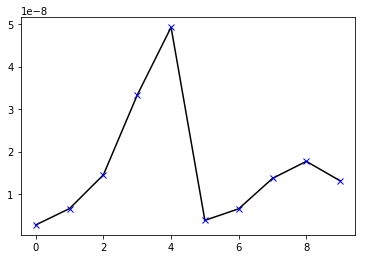

In [3]:
J_h_diff = (d_p-d_n) / (dh)
plt.plot(J_h_diff, 'k')
plt.plot(prob.getJ_height(m_true), 'bx')

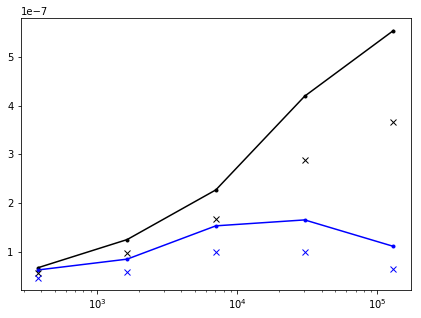

In [4]:
fig, axes = plt.subplots(1,1, figsize = (7,5))
axes.plot(FDsurvey.frequency, -d_true[0:FDsurvey.n_frequency], 'k.-')
axes.plot(FDsurvey.frequency, -d_true[FDsurvey.n_frequency:], 'b.-')
axes.plot(FDsurvey.frequency, -d_dh[0:FDsurvey.n_frequency], 'kx')
axes.plot(FDsurvey.frequency, -d_dh[FDsurvey.n_frequency:], 'bx')
axes.set_xscale('log')

In [5]:
# prob.get_threshold(uncert)

In [6]:
from SimPEG import Regularization

In [7]:
FDsurvey.dtrue = d_true
std = 0.07
floor = 0.
np.random.seed(1)
uncert = std*abs(FDsurvey.dtrue)+floor
noise = std*FDsurvey.dtrue*np.random.randn(FDsurvey.dtrue.size)
FDsurvey.dobs = FDsurvey.dtrue+noise
dmisfit = DataMisfit.l2_DataMisfit(FDsurvey)
dmisfit.W = 1./(abs(FDsurvey.dobs)*std+floor)
m0 = np.r_[np.log(np.ones_like(sig)*sig_half), 35.]
reg_sigma = Regularization.Sparse(
    mesh1D, mapping=wires.sigma
)
p=0.
qx, qz = 1., 1.
reg_sigma.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=20, minGNiter=1, fix_Jmatrix=True, coolingRate=2, 
    betaSearch=False,
    chifact_start = 1.
)
mesh_h = Mesh.TensorMesh([1])
reg_h = Regularization.Sparse(
    mesh_h, mapping=wires.h, 
    alpha_s = 1.
)
reg = reg_sigma + reg_h
opt = Optimization.ProjectedGNCG(maxIter = 40)
opt.maxIterLS = 5
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit()
update_sense = Directives.UpdateSensitivityWeights()
# inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target,update_sense])
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest,update_sense])
# inv = Inversion.BaseInversion(invProb, directiveList=[IRLS])

prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:896: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


   0  2.46e+00  1.49e+02  0.00e+00  1.49e+02    4.34e+01      0              
   1  2.46e+00  3.02e+01  5.25e+00  4.31e+01    5.67e+01      0              
   2  2.46e+00  5.07e+00  8.48e+00  2.59e+01    8.40e+00      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 3.8910506836591345 eps_q: 3.8910506836591345
eps_p: 3.8910506836591345 eps_q: 3.8910506836591345
>> Fix Jmatrix
Eps_p: 3.2425422363826124
Eps_q: 3.2425422363826124
Eps_p: 3.2425422363826124
Eps_q: 3.2425422363826124
delta phim:    inf
   3  2.46e+00  3.97e+00  8.79e+00  2.56e+01    2.27e+00      0   Skip BFGS  
>> Fix Jmatrix
Eps_p: 2.702118530318844
Eps_q: 2.702118530318844
Eps_p: 2.702118530318844
Eps_q: 2.702118530318844
delta phim: 6.735e-01
   4  3.84e+00  4.47e+00  9.20e+00  3.98e+01    8.65e+00      0              
>> Fix Jmatrix
Eps_p: 2.25176544193237
Eps_q: 2.25176544193237
Eps_p: 2.25176544193237
Eps_q: 2.25176544193237
delta phim: 5.948e-02
   5  2.14e+00  8.13e+00

In [8]:
print (wires.h*m0)
print (wires.h*mopt)
print (FDsurvey.h)

[35.]
[30.72620224]
30.0


Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pi', 'std', 'inv', 'axes', 'beta', 'floor']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


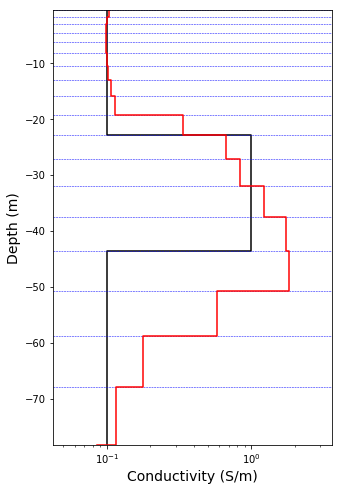

In [9]:
%pylab inline
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ, showlayers=False)
Utils1D.plotLayer(sigmaMap*mopt, LocSigZ, showlayers=True, **{'color':'r'})
# Utils1D.plotLayer(sigmaMap*invProb.l2model, LocSigZ, showlayers=True,**{'color':'g'})

In [10]:
# !python run_em1d.py

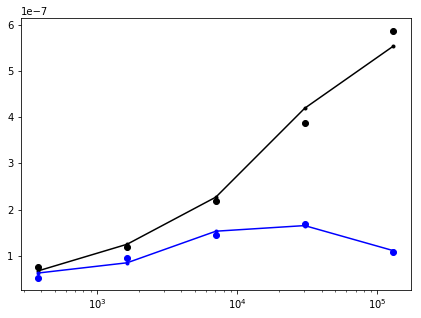

In [11]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(FDsurvey.frequency, -d_true[0:FDsurvey.n_frequency], 'k.-')
axes.plot(FDsurvey.frequency, -d_true[FDsurvey.n_frequency:], 'b.-')
axes.plot(FDsurvey.frequency, -FDsurvey.dobs[0:FDsurvey.n_frequency], 'ko')
axes.plot(FDsurvey.frequency, -FDsurvey.dobs[FDsurvey.n_frequency:], 'bo')
# axes.plot(FDsurvey.frequency, uncert[0:FDsurvey.n_frequency], 'k*')
# axes.plot(FDsurvey.frequency, uncert[FDsurvey.n_frequency:], 'r*')
axes.set_xscale('log')